In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/all-aspects/all_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect.csv
/kaggle/input/all-aspects/all_tagged_aspects_sentences.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_sentences.csv
/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled_sentences.csv
/kaggle/input/all-aspects/reviews.csv
/kaggle/input/all-aspects/cleaned.csv
/kaggle/input/all-aspects/all_aspects_just_aspect_filled.csv
/kaggle/input/all-aspects/all_tagged_aspects.csv
/kaggle/input/all-aspects/all_aspects.csv


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import torch
from torch import nn
from transformers import BertModel, BertForTokenClassification
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Dataset
from transformers import AdamW
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

In [37]:
df = pd.read_csv("/kaggle/input/all-aspects/all_tagged_aspects_just_aspect_filled_sentences.csv")
df.head()

,sentence,word_labels
0,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,"O,O,B-A,O,O,O,O,B-A,O,O,O"
1,Her güncellemede daha da kötüleşen Turkcell in...,"O,O,O,O,O,B-A,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
2,BiP’ten aranmıyor yardım,"B-A,O,O"
3,Bu yorumum kesinlikle uygulamanın daha çok gel...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-A,O,O,O,..."
4,kurumlarda WhatsApp engelleniyor Alternatif ol...,"O,B-A,O,O,O,B-A,O,O,B-A,O,O,O,O,O,O,O,B-A,O,O,..."


In [38]:
df.isnull().sum()

sentence       0
word_labels    0
dtype: int64

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [40]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("microsoft/mdeberta-v3-base")
model = AutoModelForTokenClassification.from_pretrained("microsoft/mdeberta-v3-base", num_labels=3).to(device)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:562: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
labels_to_ids = {'O': 0, 'B-A': 1, 'I-A': 2}
ids_to_labels = {0: 'O', 1: 'B-A', 2: 'I-A'}

In [42]:
MAX_LEN = 64 # Max number of tokens per sentece (BERT models have a limit of 512)
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10

In [62]:
class dataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = self.data.loc[index, 'sentence']
        labels = self.data.loc[index, 'word_labels'].split(',')

        tokens = sentence.split()
        encoding = self.tokenizer(tokens, truncation=True, is_split_into_words=True, return_tensors="pt", padding="max_length", max_length=self.max_len)

        label_ids = [-100] * len(encoding["input_ids"][0])
        word_ids = encoding.word_ids()
        previous_word_idx = None

        for idx, word_idx in enumerate(word_ids):
            if word_idx is None:
                continue
            if word_idx != previous_word_idx:
                label_ids[idx] = label2id[labels[word_idx]]
            previous_word_idx = word_idx

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label_ids)
        return item

In [63]:
train_size = 0.9
train_dataset = df.sample(frac=train_size,random_state=42)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (113210, 2)
TRAIN Dataset: (101889, 2)
TEST Dataset: (11321, 2)


In [64]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [65]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
input_ids = input_ids.type(torch.LongTensor)
attention_mask = inputs["attention_mask"].unsqueeze(0)
attention_mask = attention_mask.type(torch.LongTensor)
labels = inputs["labels"].unsqueeze(0)
labels = labels.type(torch.LongTensor)

In [67]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [68]:
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].type(torch.LongTensor).to(device)
        mask = batch['attention_mask'].type(torch.LongTensor).to(device)
        labels = batch['labels'].type(torch.LongTensor).to(device)

        output = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = output.loss.item()
        tr_logits = output.logits
        tr_loss += loss

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 1000 == 0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 1000 training steps: {loss_step}")
           
        flattened_targets = labels.view(-1) 
        active_logits = tr_logits.view(-1, model.num_labels) 
        flattened_predictions = torch.argmax(active_logits, axis=1) 
        
        active_accuracy = labels.view(-1) != -100 
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [69]:
%%time

for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 1000 training steps: 0.13207580149173737
Training loss per 1000 training steps: 0.024957584279527018
Training loss per 1000 training steps: 0.017744588444054743
Training loss per 1000 training steps: 0.015040202087303414
Training loss per 1000 training steps: 0.013783586623673457
Training loss per 1000 training steps: 0.012134362119977857
Training loss per 1000 training steps: 0.011123005991165108
Training loss per 1000 training steps: 0.010516956506463343
Training loss per 1000 training steps: 0.009816963273981264
Training loss per 1000 training steps: 0.009532858613981563
Training loss per 1000 training steps: 0.009058239540212013
Training loss per 1000 training steps: 0.008574201402940209
Training loss per 1000 training steps: 0.008397200522322307
Training loss per 1000 training steps: 0.008196662287352767
Training loss per 1000 training steps: 0.007920788513941375
Training loss per 1000 training steps: 0.007665116489046343
Training loss per 1000 

In [70]:
def valid(model, testing_loader):
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['input_ids'].type(torch.LongTensor).to(device)
            mask = batch['attention_mask'].type(torch.LongTensor).to(device)
            labels = batch['labels'].type(torch.LongTensor).to(device)

            output = model(input_ids=ids, attention_mask=mask, labels=labels)
            eval_loss = output.loss.item()
            eval_logits = output.logits

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 1000 == 0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 1000 evaluation steps: {loss_step}")
              
            flattened_targets = labels.view(-1) 
            active_logits = eval_logits.view(-1, model.num_labels) 
            flattened_predictions = torch.argmax(active_logits, axis=1) 
            
            active_accuracy = labels.view(-1) != -100 
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [71]:
%%time

labels, predictions = valid(model, testing_loader)

Validation loss per 1000 evaluation steps: 1.9258586689829826e-05
Validation loss per 1000 evaluation steps: 5.7226649581358864e-08
Validation loss per 1000 evaluation steps: 2.4225417597183043e-07
Validation loss per 1000 evaluation steps: 7.421428882374165e-09
Validation loss per 1000 evaluation steps: 2.0672705004578777e-08
Validation loss per 1000 evaluation steps: 3.3665089148240695e-09
Validation Loss: 2.9077042054229972e-09
Validation Accuracy: 0.9989283485372366
CPU times: user 2min 14s, sys: 94.9 ms, total: 2min 14s
Wall time: 2min 14s


In [72]:
def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)

    out_label_ids = label_ids.numpy()
    preds_list, out_label_list = [], []

    for pred, label in zip(preds, out_label_ids):
        pred_i = [p for p, l in zip(pred, label) if l != label_map['O']]
        label_i = [l for l in label if l != label_map['O']]
        preds_list.append(pred_i)
        out_label_list.append(label_i)

    return preds_list, out_label_list

In [75]:
recall_val = recall_score(y_true = labels, y_pred = predictions, average= 'macro')
print(f'Recall: {recall_val}')

precision_val = precision_score(y_true = labels, y_pred = predictions, average= 'macro')
print(f'Precision: {precision_val}')

f1_val = f1_score(y_true = labels, y_pred = predictions, average= 'macro')
print(f'f1 score: {f1_val}')

print(confusion_matrix(y_true = labels, y_pred = predictions))

Recall: 0.961432202818968
Precision: 0.9875192111778718
f1 score: 0.9739625160410851
----------------------------
[[ 14866      1     94]
 [    15    490     45]
 [    32     16 182712]]


In [76]:
sentence = "Fiber 100mb SuperOnline kullanıcısıyım yaklaşık 2 haftadır Twitch Kick_Turkey gibi canlı yayın platformlarında 360p yayın izlerken donmalar yaşıyoruz. Başka hiç bir operatörler bu sorunu yaşamazken ben parasını verip alamadığım hizmeti neden ödeyeyim ? Turkcell "
#sentence = 	"Türk Telekom da İnternetiniz yokken bile msj atilio"

In [77]:
inputs = tokenizer(sentence, return_offsets_mapping=True, padding='max_length',  truncation=True, max_length=MAX_LEN, return_tensors="pt")

In [82]:
def align_word_predictions(tokens, token_predictions):
    aligned_tokens = []
    aligned_predictions = []

    for token, prediction in zip(tokens, token_predictions):
        if not token.startswith("_"):
            aligned_tokens.append(token)
            aligned_predictions.append(prediction)
        else:
            aligned_tokens[-1] = aligned_tokens[-1] + token[2:]

    return aligned_tokens, aligned_predictions

In [83]:
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)

with torch.no_grad():
    outputs = model(ids, attention_mask=mask)
    logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) 
flattened_predictions = torch.argmax(active_logits, axis=1) 

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

In [84]:
aligned_tokens, aligned_predictions = align_word_predictions(tokens, token_predictions)

for token, prediction in zip(aligned_tokens, aligned_predictions):
    print(f"{token}: {prediction}")

[CLS]: O
▁Fiber: O
▁100: O
mb: O
▁Super: B-A
Online: B-A
▁k: O
ullanıcı: O
s: O
ıyım: O
▁yaklaş: O
ık: O
▁2: O
▁: O
hafta: O
dır: O
▁T: B-A
witch: B-A
▁Kick: O
Turkey: O
▁gibi: O
▁: O
canlı: O
▁yayın: O
▁platform: O
larında: O
▁360: O
p: O
▁yayın: O
▁iz: O
lerken: O
▁don: O
malar: O
▁yaş: O
ıyoruz: O
.: O
▁Başka: O
▁hi: O
ç: O
▁bir: O
▁operat: B-A
örler: O
▁bu: O
▁sorun: O
u: O
▁yaşam: O
azken: O
▁ben: O
▁para: O
sını: O
▁ver: O
ip: O
▁alama: O
dığım: O
▁hizmet: O
i: O
▁neden: O
▁öde: O
y: O
eyim: O
▁: O
?: O
[SEP]: O


In [85]:
def predict_sentence(model, sentence, word_tokenizer, tag_tokenizer, maxlen, device): 
    predicted_tags = [tag_reverse_map[idx] for idx in predicted_tags if idx != 0]

    filtered_tokens = [token for token in tokens if token not in ["[PAD]", "[CLS]", "[SEP]"]]
    filtered_predictions = [pred for token, pred in zip(tokens, predicted_tags) if token not in ["[PAD]", "[CLS]", "[SEP]"]]

    aligned_tokens, aligned_predictions = align_word_predictions(filtered_tokens, filtered_predictions)

    print("Sample input sentence:")
    print("{:15}||{}".format("Word", "Pred"))
    print(30 * "=")
    for w, pred in zip(aligned_tokens, aligned_predictions):
        print("{:15}||{}".format(w, pred))

    return aligned_tokens, aligned_predictions

In [86]:
print("Sample input sentence:")
print("{:30}||{:10}".format("Word", "Pred"))
print(30 * "=")
for w, pred in zip(aligned_tokens, aligned_predictions):
    if w not in ["[PAD]", "[CLS]", "[SEP]"]:
        print("{:30}||{:10}".format(w, pred))

Sample input sentence:
Word                          ||Pred      
▁Fiber                        ||O         
▁100                          ||O         
mb                            ||O         
▁Super                        ||B-A       
Online                        ||B-A       
▁k                            ||O         
ullanıcı                      ||O         
s                             ||O         
ıyım                          ||O         
▁yaklaş                       ||O         
ık                            ||O         
▁2                            ||O         
▁                             ||O         
hafta                         ||O         
dır                           ||O         
▁T                            ||B-A       
witch                         ||B-A       
▁Kick                         ||O         
Turkey                        ||O         
▁gibi                         ||O         
▁                             ||O         
canlı                         |

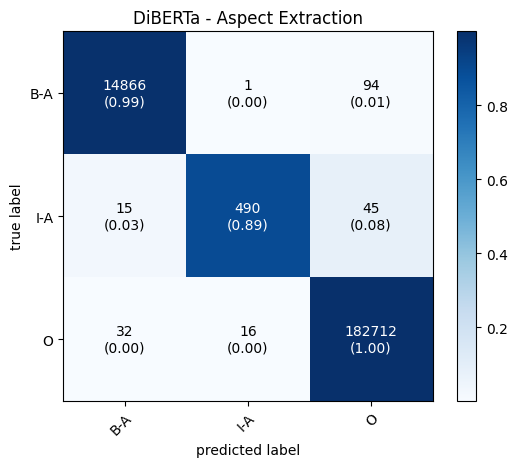

In [87]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true = labels, y_pred =predictions)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True, class_names=lab)
plt.title("DiBERTa - Aspect Extraction")
plt.show()

In [88]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         B-A       1.00      0.99      1.00     14961
         I-A       0.97      0.89      0.93       550
           O       1.00      1.00      1.00    182760

    accuracy                           1.00    198271
   macro avg       0.99      0.96      0.97    198271
weighted avg       1.00      1.00      1.00    198271



In [89]:
model.save_pretrained("./deberta_aspect_extraction_model")
tokenizer.save_pretrained("./deberta_aspect_extraction_tokenizer")

('./deberta_aspect_extraction_tokenizer/tokenizer_config.json',
 './deberta_aspect_extraction_tokenizer/special_tokens_map.json',
 './deberta_aspect_extraction_tokenizer/spm.model',
 './deberta_aspect_extraction_tokenizer/added_tokens.json',
 './deberta_aspect_extraction_tokenizer/tokenizer.json')